# Problem statement
	• Objective: Predict the loan outcome (good/bad) at the time of application using data provided in JSON and CSV formats.
	• Evaluation Metric: ROC AUC score.
Output: Final prediction CSV file named final_submission_Vaibhav_Jain.csv with the same format as sample_submission.csv.

# Understanding data
1. **Flag**: Whether client provided loan or not to the customer.

2. **Accounts Data**: Details of loans taken by the borrower before they applied for a loan from your client. These details were collected when the borrower applied for a loan from your client.

3. **Enquiry Data**: This contains details of previous loan applications made by the applicant. These applications may or may not be successful.


## Data dictionary

### Flag Data Details

| Field Name           | Explanation                                                |
|----------------------|------------------------------------------------------------|
| `uid`                | A unique ID used to identify the applicant                 |
| `NAME_CONTRACT_TYPE` | Type of loan that has been given to the borrower            |
| `TARGET`             | Boolean field that represents the outcome of the loan. 1 = bad loan, 0 = good loan |


### Accounts Data Details

| Field Name       | Explanation                                                  |
|------------------|--------------------------------------------------------------|
| `uid`            | A unique ID used to identify the applicant                  |
| `credit_type`    | The type of the loan.                                        |
| `loan_amount`    | The principal amount of the loan.                            |
| `amount_overdue` | The amount of the loan that is currently past due date.      |
| `open_date`      | Date on which the loan was sanctioned.                       |
| `closed_date`    | Date on which the loan was closed. If the loan is running, this is missing. |


### Enquiry Data Details

| Field Name            | Explanation                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| `uid`                 | A unique ID used to identify the applicant                                    |
| `enquiry_type`        | The type of the loan that was applied for.                                    |
| `enquiry_amt`         | The requested loan amount.                                                    |
| `enquiry_date`        | The date on which the application was made.                                   |
| `payment_hist_string` | A month-by-month repayment history for that loan. Three digits represent the payment history for a single month. The numeric value represents the number of days overdue for that month. The most recent payment is on the right of the string. For example, if the string is ‘000026’ then the borrower was 26 days past the due date when making the payment for the most recent month, but was on-time (0 days past due) for the month before that. |


In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb


# Set option to display all columns
pd.set_option('display.max_columns', None)

# Ignore warnings
warnings.filterwarnings('ignore')

# Load data

In [4]:
# train data

train_flag = pd.read_csv('data/train/train_flag.csv')

In [6]:
train_flag.shape

(261383, 3)

In [10]:
train_flag.sample(5)

,uid,NAME_CONTRACT_TYPE,TARGET
191955,FSF63751000,Revolving loans,0
79026,BWH49336885,Revolving loans,0
150006,PCV26298791,Cash loans,0
22125,KGF92124595,Cash loans,1
250205,CRQ20186180,Cash loans,0


In [132]:
# train_enquiry data

train_enquiry = pd.read_json('data/train/enquiry_data_train.json')

In [133]:
train_enquiry.shape

(261383, 69)

In [134]:
train_enquiry.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
0,"{'enquiry_type': 'Interbank credit', 'enquiry_...","{'enquiry_type': 'Mobile operator loan', 'enqu...","{'enquiry_type': 'Mobile operator loan', 'enqu...","{'enquiry_type': 'Interbank credit', 'enquiry_...","{'enquiry_type': 'Cash loan (non-earmarked)', ...","{'enquiry_type': 'Mortgage', 'enquiry_amt': 44...","{'enquiry_type': 'Revolving loans', 'enquiry_a...","{'enquiry_type': 'Interbank credit', 'enquiry_...",{'enquiry_type': 'Loan for purchase of shares ...,"{'enquiry_type': 'Revolving loans', 'enquiry_a...",{'enquiry_type': 'Loan for purchase of shares ...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,"{'enquiry_type': 'Cash loans', 'enquiry_amt': ...","{'enquiry_type': 'Interbank credit', 'enquiry_...","{'enquiry_type': 'Car loan', 'enquiry_amt': 12...","{'enquiry_type': 'Revolving loans', 'enquiry_a...","{'enquiry_type': 'Car loan', 'enquiry_amt': 12...","{'enquiry_type': 'Another type of loan', 'enqu...",{'enquiry_type': 'Loan for the purchase of equ...,"{'enquiry_type': 'Real estate loan', 'enquiry_...","{'enquiry_type': 'Credit card', 'enquiry_amt':...","{'enquiry_type': 'Unknown type of loan', 'enqu...","{'enquiry_type': 'Cash loans', 'enquiry_amt': ...","{'enquiry_type': 'Another type of loan', 'enqu...","{'enquiry_type': 'Cash loans', 'enquiry_amt': ...","{'enquiry_type': 'Cash loans', 'enquiry_amt': ...","{'enquiry_type': 'Another type of loan', 'enqu...","{'enquiry_type': 'Cash loans', 'enquiry_amt': ...","{'enquiry_type': 'Microloan', 'enquiry_amt': 4...","{'enquiry_type': 'Consumer credit', 'enquiry_a...","{'enquiry_type': 'Microloan', 'enquiry_amt': 9...","{'enquiry_type': 'Interbank credit', 'enquiry_...","{'enquiry_type': 'Car loan', 'enquiry_amt': 50...","{'enquiry_type': 'Mortgage', 'enquiry_amt': 32...","{'enquiry_type': 'Cash loans', 'enquiry_amt': ...","{'enquiry_type': 'Cash loan (non-earmarked)', ...","{'enquiry_type': 'Mobile operator loan', 'enqu...","{'enquiry_type': 'Cash loans', 'enquiry_amt': ...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [167]:
f = open('data/train/enquiry_data_train.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

unq_lst=[]

for val in data:
    unq_lst.extend(val)
    

train_enquiry = pd.json_normalize(unq_lst)

In [168]:
train_enquiry.shape

(1909926, 4)

In [169]:
train_enquiry.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [170]:
train_flag[train_flag.uid=='AAA08065248']

,uid,NAME_CONTRACT_TYPE,TARGET
160539,AAA08065248,Revolving loans,0


In [56]:
# train accounts data

f = open('data/train/accounts_data_train.json')
# returns JSON object as a dictionary
data = json.load(f)
unq_lst=[]
for val in data:
    unq_lst.extend(val)
    
train_account = pd.json_normalize(unq_lst)

In [57]:
train_account.shape

(1245310, 7)

In [59]:
train_account.sample(5)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
675112,Consumer credit,18517.5,0.0,2019-02-15,2019-03-19,000,OCO90549125
919475,Credit card,180000.0,0.0,2019-01-12,NaN,0000000000000000000000000000000000000000000000...,TEU14171866
338944,Consumer credit,103500.0,0.0,2018-08-12,2019-08-13,000000000000000000000000000000000000,HAX18849965
470292,Mortgage,12890407.5,0.0,2017-11-13,NaN,0000000000000000000000000000000000000000000000...,JUI14768013
308097,Consumer credit,112500.0,0.0,2020-09-08,NaN,000000000,GKE78017740


# Pre-processing

In [139]:
train_flag.sample(4)

,uid,NAME_CONTRACT_TYPE,TARGET
64208,GMG46612459,Cash loans,0
106531,ZGD81778817,Cash loans,0
7135,LBG08339307,Cash loans,0
192505,RFY98844710,Cash loans,0


In [140]:
train_flag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   uid                 261383 non-null  object
 1   NAME_CONTRACT_TYPE  261383 non-null  object
 2   TARGET              261383 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 4.2+ MB


In [141]:
# strip spances for key
train_flag['uid'] = train_flag['uid'].str.strip()

In [142]:
# check for duplicates
train_flag.uid.duplicated().sum()

0

In [143]:
train_flag.TARGET.value_counts(dropna=False)

TARGET
0    240326
1     21057
Name: count, dtype: int64

In [144]:
train_flag.TARGET.sample()

17254    0
Name: TARGET, dtype: int8

In [145]:
# change type of TARGET to int8
train_flag.TARGET = train_flag.TARGET.astype('int8')

In [ ]:
# enquiry data 

In [171]:
train_enquiry.sample(3)

,enquiry_type,enquiry_amt,enquiry_date,uid
71707,Loan for business development,115000,2020-12-13,AZR19423494
527201,Cash loan (non-earmarked),111000,2019-06-22,HED64050365
1269865,Credit card,154000,2020-07-06,RGR50706026


In [205]:
train_enquiry.shape

(1909926, 4)

In [206]:
train_enquiry['uid'].duplicated().sum()

1648543

In [207]:
1909926-1648543

261383

In [208]:
train_enquiry.isna().sum()

enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64

In [182]:
train_enquiry.head(5)

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [183]:
train_enquiry[train_enquiry.uid=='AAA08065248']

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248
5,Mortgage,44841,2019-11-03,AAA08065248
6,Revolving loans,364751,2020-02-26,AAA08065248
7,Interbank credit,127618,2020-10-04,AAA08065248
8,Loan for purchase of shares (margin lending),315591,2019-06-12,AAA08065248
9,Revolving loans,169056,2019-03-01,AAA08065248


In [ ]:
# Aggregating train_enquiry 

In [178]:
# Convert enquiry_date to datetime
train_enquiry['enquiry_date'] = pd.to_datetime(train_enquiry['enquiry_date'])

In [215]:
# Aggregation by uid
aggregated_enquiry_df = train_enquiry.groupby('uid').agg(
    enquiry_count=('enquiry_amt', 'count'),
    avg_enquiry_amt=('enquiry_amt', 'mean'),
    recent_enquiry_date=('enquiry_date', 'max'),
    days_since_last_enquiry=('enquiry_date', lambda x: (pd.to_datetime('today') - x.max()).days),
    most_recent_enquiry_amt=('enquiry_amt', lambda x: x.loc[x.idxmax()])
)

# Reset index to make uid a column again
aggregated_enquiry_df = aggregated_enquiry_df.reset_index()

In [216]:
print(aggregated_enquiry_df.shape)
aggregated_enquiry_df.head()

(261383, 6)


,uid,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt
0,AAA08065248,11,187696.181818,2020-12-30,1336,364751
1,AAA09044550,26,102269.230769,2020-12-29,1337,197000
2,AAA10545297,14,94071.428571,2020-10-29,1398,192000
3,AAA14112888,15,97666.666667,2020-07-05,1514,185000
4,AAA20326915,1,66000.000000,2020-08-14,1474,66000


In [217]:
en = aggregated_enquiry_df.copy()

In [218]:
en.enquiry_count.value_counts(dropna=False)

enquiry_count
1     56211
2     23789
3     21141
4     18981
5     16857
      ...  
56        2
60        1
69        1
62        1
57        1
Name: count, Length: 63, dtype: int64

In [187]:
train_enquiry.enquiry_type.value_counts(dropna=False)

enquiry_type
Cash loans                                      303108
Revolving loans                                 120181
Mobile operator loan                             99479
Real estate loan                                 99328
Microloan                                        99324
Unknown type of loan                             99280
Loan for purchase of shares (margin lending)     99230
Mortgage                                         99216
Credit card                                      99208
Another type of loan                             99154
Loan for the purchase of equipment               99152
Interbank credit                                 99063
Car loan                                         98994
Loan for business development                    98900
Cash loan (non-earmarked)                        98831
Loan for working capital replenishment           98814
Consumer credit                                  98664
Name: count, dtype: int64

In [ ]:
# we know that in flag data only cash and revolving loans are there, so didnt aggrgate for enquiry type
# in the future potential aggragation feature can include counts according to each oh the two types etc.

# EDA

## train_flag

In [189]:
train_flag.isna().sum()

uid                   0
NAME_CONTRACT_TYPE    0
TARGET                0
dtype: int64

In [193]:
train_flag.NAME_CONTRACT_TYPE.value_counts(dropna=False,normalize=True)*100

NAME_CONTRACT_TYPE
Cash loans         90.489435
Revolving loans     9.510565
Name: proportion, dtype: float64

In [194]:
train_flag.TARGET.value_counts(dropna=False, normalize=True)*100

TARGET
0    91.944006
1     8.055994
Name: proportion, dtype: float64

In [201]:
fil = train_flag[train_flag.NAME_CONTRACT_TYPE=='Revolving loans']

In [202]:
fil.TARGET.value_counts(dropna=False)

TARGET
0    23503
1     1356
Name: count, dtype: int64

In [203]:
fil = train_flag[train_flag.NAME_CONTRACT_TYPE=='Cash loans']

In [204]:
fil.TARGET.value_counts(dropna=False)

TARGET
0    216823
1     19701
Name: count, dtype: int64

In [ ]:
# potential Class imbalance

## train_enquiry

In [210]:
train_enquiry.sample(3)

,enquiry_type,enquiry_amt,enquiry_date,uid
1437030,Car loan,36000,2019-12-16,TOB18219380
286517,Loan for working capital replenishment,14000,2020-11-21,DYF52266933
1569731,Loan for working capital replenishment,78000,2020-12-28,VIW53142079


In [244]:
train_enquiry.isna().sum()

enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64

In [211]:
train_enquiry.enquiry_type.value_counts(dropna=False, normalize=True)*100

enquiry_type
Cash loans                                      15.870144
Revolving loans                                  6.292443
Mobile operator loan                             5.208526
Real estate loan                                 5.200620
Microloan                                        5.200411
Unknown type of loan                             5.198107
Loan for purchase of shares (margin lending)     5.195489
Mortgage                                         5.194756
Credit card                                      5.194337
Another type of loan                             5.191510
Loan for the purchase of equipment               5.191405
Interbank credit                                 5.186745
Car loan                                         5.183133
Loan for business development                    5.178211
Cash loan (non-earmarked)                        5.174598
Loan for working capital replenishment           5.173708
Consumer credit                                  5.165855
N

In [219]:
en.shape

(261383, 6)

In [220]:
en.sample(5)

,uid,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt
60852,GBM85785170,5,106200.000000,2020-12-23,1343,194000
251551,ZAP27410028,11,95818.181818,2020-12-22,1344,189000
195289,TKS80093066,21,113142.857143,2020-11-21,1375,199000
12811,BHQ48077148,1,94000.000000,2020-08-22,1466,94000
153577,PGX30484067,4,113500.000000,2020-08-25,1463,182000


In [223]:
en.enquiry_count.value_counts(normalize=100)*100

enquiry_count
1     21.505224
2      9.101204
3      8.088131
4      7.261758
5      6.449157
        ...    
56     0.000765
60     0.000383
69     0.000383
62     0.000383
57     0.000383
Name: proportion, Length: 63, dtype: float64

<Axes: xlabel='enquiry_count', ylabel='Count'>

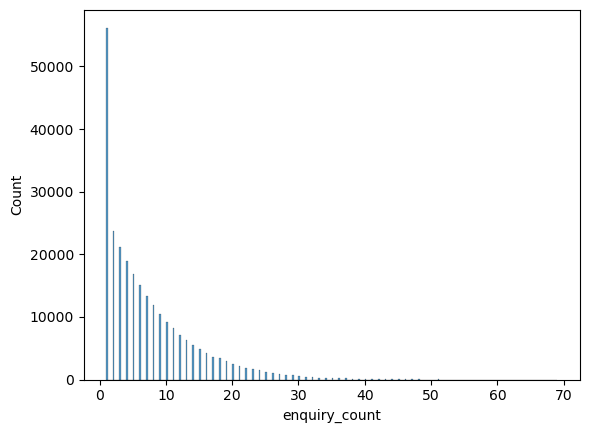

In [221]:
sns.histplot(en.enquiry_count)

<Axes: xlabel='avg_enquiry_amt', ylabel='Count'>

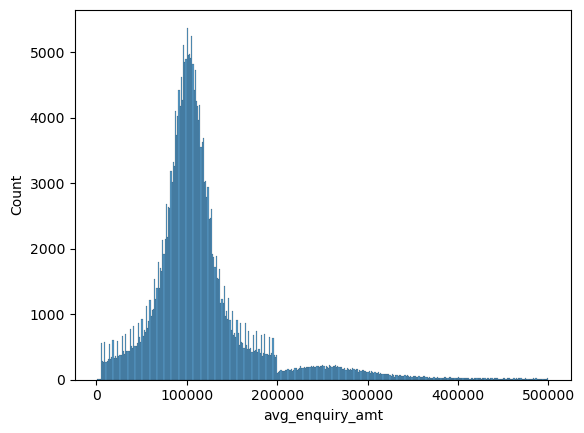

In [224]:
sns.histplot(en.avg_enquiry_amt)

<Axes: xlabel='avg_enquiry_amt', ylabel='enquiry_count'>

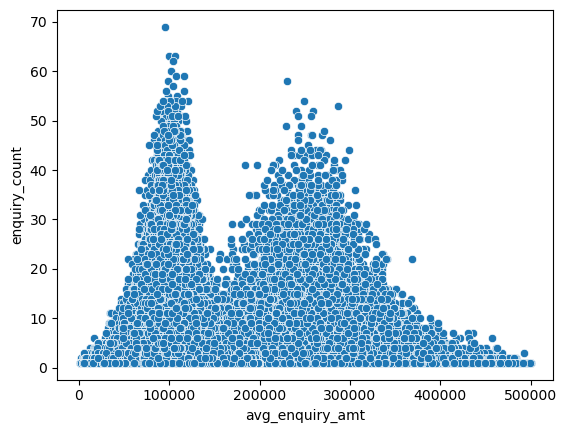

In [226]:
sns.scatterplot(x=en.avg_enquiry_amt, y=en.enquiry_count)

<Axes: xlabel='most_recent_enquiry_amt', ylabel='Count'>

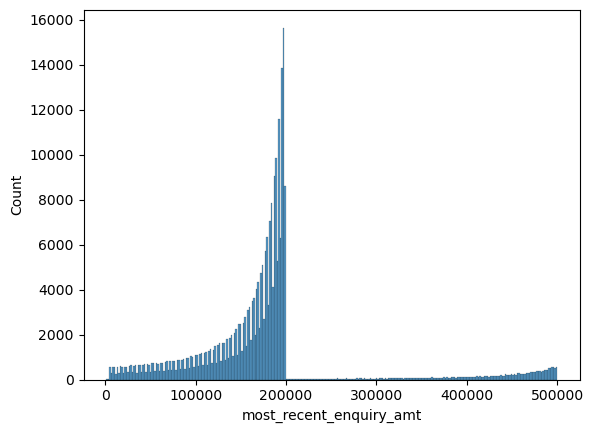

In [227]:
sns.histplot(en.most_recent_enquiry_amt)

<Axes: xlabel='most_recent_enquiry_amt', ylabel='enquiry_count'>

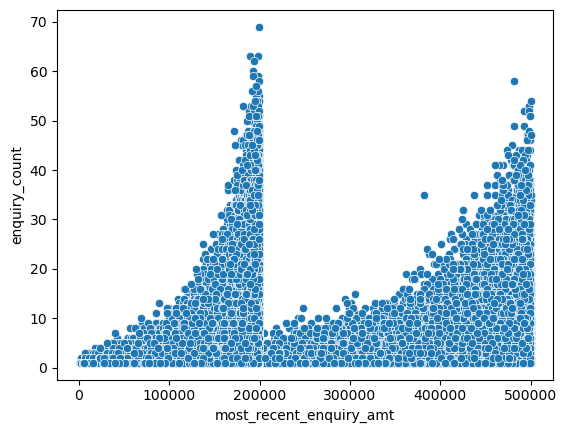

In [228]:
sns.scatterplot(x=en.most_recent_enquiry_amt, y=en.enquiry_count)

<Axes: xlabel='days_since_last_enquiry', ylabel='Count'>

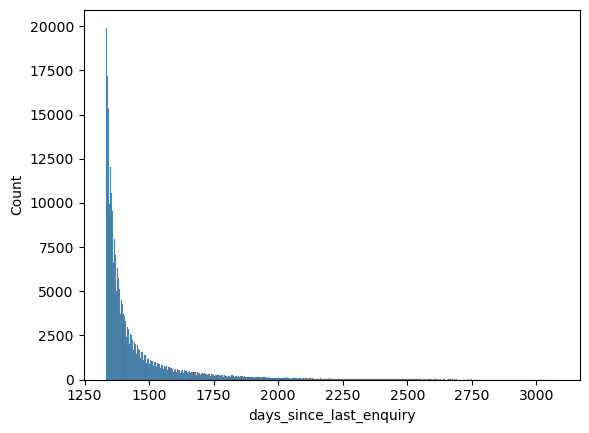

In [229]:
sns.histplot(en.days_since_last_enquiry)

In [231]:
# Update days_since_last_enquiry to zero where enquiry_count is 1
en['days_since_last_enquiry'] = en.apply(
    lambda row: 0 if row['enquiry_count'] == 1 else row['days_since_last_enquiry'],
    axis=1
)

<Axes: xlabel='days_since_last_enquiry', ylabel='Count'>

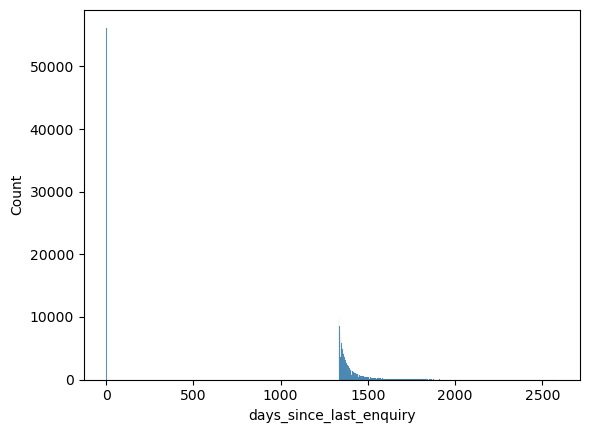

In [232]:
sns.histplot(en.days_since_last_enquiry)

<Axes: xlabel='recent_enquiry_date', ylabel='Count'>

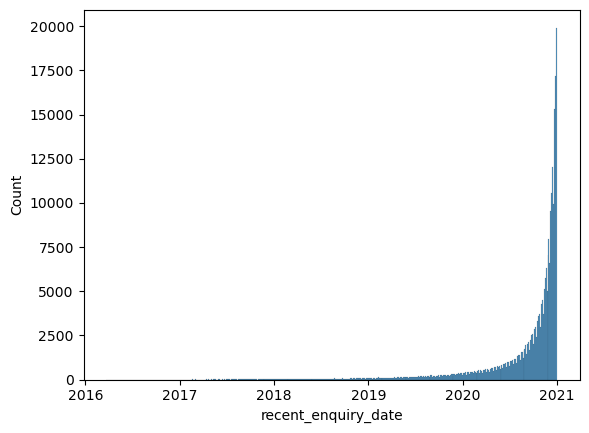

In [234]:
sns.histplot(en.recent_enquiry_date)

<Axes: xlabel='most_recent_enquiry_amt', ylabel='recent_enquiry_date'>

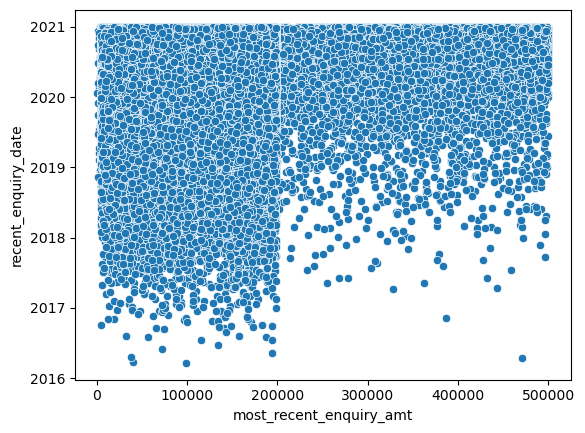

In [238]:
sns.scatterplot(x=en.most_recent_enquiry_amt, y=en.recent_enquiry_date)

## train_account

In [239]:
train_account.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915


In [240]:
train_account.shape

(1245310, 7)

In [241]:
train_flag.shape

(261383, 3)

In [242]:
1245310-261383

983927

In [243]:
train_account.isna().sum()

credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
dtype: int64

In [245]:
train_account.uid.duplicated().sum()

1021392

In [246]:
1245310-1021392

223918

In [247]:
en.shape

(261383, 6)

In [254]:
# it look like account coverage may not be complete

# Step 1: Identify uids in train_flag that are not in train_account
uids_not_in_train_account = train_flag[~train_flag['uid'].isin(train_account['uid'])]

# Step 2: Count the number of uids for each TARGET value
target_counts = uids_not_in_train_account['TARGET'].value_counts()

# Step 3: Calculate the percentage of missing uids for each TARGET value
total_counts = train_flag['TARGET'].value_counts()
percentage_missing = (target_counts / total_counts) * 100

# Combine counts and percentages
result = pd.DataFrame({'Count': target_counts, 'Percentage Missing': percentage_missing})

print(result)

        Count  Percentage Missing
TARGET                           
0       33665           14.008056
1        3800           18.046255


In [255]:
train_flag.TARGET.value_counts()

TARGET
0    240326
1     21057
Name: count, dtype: int64

In [257]:
train_account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245310 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   credit_type          1245310 non-null  object 
 1   loan_amount          1245307 non-null  float64
 2   amount_overdue       1245310 non-null  float64
 3   open_date            1245310 non-null  object 
 4   closed_date          782275 non-null   object 
 5   payment_hist_string  1245310 non-null  object 
 6   uid                  1245310 non-null  object 
dtypes: float64(2), object(5)
memory usage: 66.5+ MB


In [192]:
train_account.credit_type.value_counts(dropna=False, normalize=True)*100

credit_type
Consumer credit                                 72.973075
Credit card                                     23.481864
Car loan                                         1.625057
Mortgage                                         1.059656
Microloan                                        0.623620
Loan for business development                    0.117722
Another type of loan                             0.058781
Unknown type of loan                             0.030033
Loan for working capital replenishment           0.025696
Real estate loan                                 0.001365
Cash loan (non-earmarked)                        0.001365
Loan for the purchase of equipment               0.001285
Loan for purchase of shares (margin lending)     0.000321
Interbank credit                                 0.000080
Mobile operator loan                             0.000080
Name: proportion, dtype: float64

In [258]:
# Convert dates to datetime
train_account['open_date'] = pd.to_datetime(train_account['open_date'])
train_account['closed_date'] = pd.to_datetime(train_account['closed_date'])

# Create a flag for ongoing loans (1 if ongoing, 0 if closed)
train_account['ongoing_loan'] = train_account['closed_date'].isna().astype(int)

In [260]:
# Convert date columns to datetime
train_account['open_date'] = pd.to_datetime(train_account['open_date'])
train_account['closed_date'] = pd.to_datetime(train_account['closed_date'])

# Calculate loan duration
train_account['loan_duration'] = (train_account['closed_date'] - train_account['open_date']).dt.days

# If closed_date is missing, calculate the duration from open_date to today
train_account['loan_duration'] = train_account['loan_duration'].fillna(
    (pd.to_datetime('today') - train_account['open_date']).dt.days
)

In [263]:
# Extract year, month, and day from open_date
train_account['open_year'] = train_account['open_date'].dt.year
train_account['open_month'] = train_account['open_date'].dt.month

# Similarly, extract features from closed_date if needed
train_account['closed_year'] = train_account['closed_date'].dt.year
train_account['closed_month'] = train_account['closed_date'].dt.month

# Fill missing date features for ongoing loans, if necessary
train_account['closed_year'].fillna(0, inplace=True)
train_account['closed_month'].fillna(0, inplace=True)

In [272]:
# Function to calculate average days overdue from payment_hist_string
def calc_avg_days_overdue(payment_hist):
    # Convert payment history string to a list of integers
    days_overdue_list = [int(payment_hist[i:i+3]) for i in range(0, len(payment_hist), 3)]
    
    # Check if the list is empty to avoid division by zero
    if len(days_overdue_list) == 0:
        return 0  # or you can return None, np.nan, etc. depending on your use case
    
    # Return the average of days overdue
    return math.ceil(sum(days_overdue_list) / len(days_overdue_list))

# Apply the function to create a new column for average days overdue
train_account['avg_days_overdue'] = train_account['payment_hist_string'].apply(calc_avg_days_overdue)

In [277]:
train_account.sample(5)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,ongoing_loan,loan_duration,open_year,open_month,closed_year,closed_month,avg_days_overdue
469199,Consumer credit,20340.0,0.0,2013-06-23,2013-12-28,000000000000000000,JTR89572075,0,188.0,2013,6,2013.0,12.0,0
820008,Credit card,0.0,0.0,2020-08-13,NaT,000000000000,RCU08084096,1,1475.0,2020,8,0.0,0.0,0
1230076,Consumer credit,2025000.0,0.0,2019-10-17,NaT,000000000000000000000000000014044074104000,ZRQ60102864,1,1776.0,2019,10,0.0,0.0,17
462963,Credit card,135000.0,0.0,2019-11-14,NaT,000000000000000000000000015045075000000,JQI44890025,1,1748.0,2019,11,0.0,0.0,11
493270,Consumer credit,24655.5,0.0,2018-09-23,2019-08-16,000000000000000000000000000000,KHD63740725,0,327.0,2018,9,2019.0,8.0,0


In [274]:
train_account.avg_days_overdue.value_counts()

avg_days_overdue
0      1139381
1        16377
2        15111
3        11368
4         8442
        ...   
266          1
381          1
293          1
224          1
279          1
Name: count, Length: 372, dtype: int64

In [278]:
# Aggregation by uid
aggregated_account_df = train_account.groupby('uid').agg(
    total_loan_amount=('loan_amount', 'sum'),
    avg_loan_amount=('loan_amount', 'mean'),
    total_amount_overdue=('amount_overdue', 'sum'),
    max_amount_overdue=('amount_overdue', 'max'),
    avg_amount_overdue=('amount_overdue', 'mean'),
    ongoing_loan_count=('closed_date', lambda x: x.isna().sum()),
    closed_loan_count=('closed_date', lambda x: x.notna().sum()),
    avg_loan_duration=('loan_duration', 'mean'),
    loan_type_diversity=('credit_type', 'nunique'),
    avg_days_overdue=('avg_days_overdue', 'mean')  # Include average days overdue
).reset_index()

In [279]:
aggregated_account_df

,uid,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue
0,AAA09044550,277245.000,1.386225e+05,0.0,0.0,0.0,0,2,511.000000,1,2.500000
1,AAA10545297,80996.445,8.099645e+04,0.0,0.0,0.0,1,0,1520.000000,1,0.000000
2,AAA14112888,43771.500,4.377150e+04,0.0,0.0,0.0,0,1,92.000000,1,0.000000
3,AAA20326915,591597.000,7.394962e+04,0.0,0.0,0.0,3,5,1078.000000,2,23.875000
4,AAA31604840,1591960.500,3.183921e+05,0.0,0.0,0.0,3,2,1284.200000,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
223913,ZZZ74526004,113593.500,3.786450e+04,0.0,0.0,0.0,0,3,289.333333,1,3.000000
223914,ZZZ78449185,649840.500,9.283436e+04,0.0,0.0,0.0,0,7,317.428571,1,0.142857
223915,ZZZ79008454,5016064.500,1.672022e+06,127260.0,73818.0,42420.0,2,1,1398.666667,1,2.000000
223916,ZZZ81253108,5337720.000,1.334430e+06,0.0,0.0,0.0,3,1,1472.250000,3,1.000000


In [280]:
train_account.shape

(1245310, 14)

In [281]:
en.shape

(261383, 6)

In [296]:
# Merge train_flag with aggregated_account_df
final_df = train_flag.merge(aggregated_account_df, on='uid', how='left')

# create an indicator variable
final_df['missing_account_data'] = final_df[['total_loan_amount', 'avg_loan_amount', 'total_amount_overdue', 'max_amount_overdue', 'avg_amount_overdue', 'ongoing_loan_count', 'closed_loan_count', 'avg_loan_duration', 'loan_type_diversity', 'avg_days_overdue']].isna().any(axis=1).astype(int)

# Handle missing values
final_df.fillna(0, inplace=True)  # Impute with 0, adjust as needed

In [297]:
final_df.sample(5)

,uid,NAME_CONTRACT_TYPE,TARGET,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue,missing_account_data
174358,POW24538040,Cash loans,0,1025689.50,128211.187500,0.0,0.0,0.0,4.0,4.0,938.500000,2.0,0.0,0
97452,CIS23684336,Cash loans,0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
169056,HZU66506149,Revolving loans,0,74616.39,74616.390000,0.0,0.0,0.0,0.0,1.0,183.000000,1.0,0.0,0
131895,WTF51564516,Cash loans,0,437268.15,62466.878571,0.0,0.0,0.0,3.0,4.0,1164.857143,2.0,0.0,0
194170,CJF71337565,Cash loans,0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1


In [298]:
en.head()

,uid,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt
0,AAA08065248,11,187696.181818,2020-12-30,1336,364751
1,AAA09044550,26,102269.230769,2020-12-29,1337,197000
2,AAA10545297,14,94071.428571,2020-10-29,1398,192000
3,AAA14112888,15,97666.666667,2020-07-05,1514,185000
4,AAA20326915,1,66000.000000,2020-08-14,0,66000


In [299]:
final_df = final_df.merge(en, on='uid', how='left')

In [300]:
final_df.sample(5)

,uid,NAME_CONTRACT_TYPE,TARGET,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue,missing_account_data,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt
49902,PPM51769174,Cash loans,0,715486.140,357743.07000,0.0,0.0,0.0,1.0,1.0,948.500000,1.0,0.000000,0,2,107500.000000,2020-06-05,1544,178000
192407,PEZ46969304,Cash loans,0,3451326.165,493046.59500,0.0,0.0,0.0,5.0,2.0,1420.000000,2.0,0.428571,0,6,96166.666667,2020-12-15,1351,180000
169023,QJP75663819,Cash loans,0,1001079.000,166846.50000,0.0,0.0,0.0,1.0,5.0,715.166667,1.0,0.000000,0,5,96600.000000,2020-12-07,1359,145000
139156,UYH14663676,Cash loans,0,2847521.475,711880.36875,0.0,0.0,0.0,1.0,3.0,444.500000,3.0,0.000000,0,20,122450.000000,2020-12-12,1354,199000
224943,ERC17058801,Cash loans,0,2842110.000,355263.75000,0.0,0.0,0.0,3.0,5.0,1248.500000,3.0,3.250000,0,5,120000.000000,2020-06-25,1524,199000


In [301]:
final_df[final_df.uid=='GCC73690549']

,uid,NAME_CONTRACT_TYPE,TARGET,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue,missing_account_data,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt
10231,GCC73690549,Cash loans,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,77250.0,2020-06-16,1533,118000


In [302]:
train_account[train_account.uid=='GCC73690549']

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,ongoing_loan,loan_duration,open_year,open_month,closed_year,closed_month,avg_days_overdue


In [303]:
train_flag[train_flag.uid=='GCC73690549']

,uid,NAME_CONTRACT_TYPE,TARGET
10231,GCC73690549,Cash loans,1


In [304]:
train_enquiry[train_enquiry.uid=='GCC73690549']

,enquiry_type,enquiry_amt,enquiry_date,uid
447598,Mortgage,118000,2019-12-10,GCC73690549
447599,Consumer credit,15000,2019-11-24,GCC73690549
447600,Credit card,102000,2018-08-26,GCC73690549
447601,Credit card,74000,2020-06-16,GCC73690549


In [305]:
final_df.missing_account_data.value_counts()

missing_account_data
0    223917
1     37466
Name: count, dtype: int64

In [307]:
en.head()

,uid,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt
0,AAA08065248,11,187696.181818,2020-12-30,1336,364751
1,AAA09044550,26,102269.230769,2020-12-29,1337,197000
2,AAA10545297,14,94071.428571,2020-10-29,1398,192000
3,AAA14112888,15,97666.666667,2020-07-05,1514,185000
4,AAA20326915,1,66000.000000,2020-08-14,0,66000


In [308]:
final_df.head()

,uid,NAME_CONTRACT_TYPE,TARGET,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue,missing_account_data,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt
0,XDA69787158,Cash loans,0,450000.0,450000.0,0.0,0.0,0.0,1.0,0.0,2522.0,1.0,0.0,0,2,135500.000000,2020-08-07,1481,166000
1,BSE47789733,Cash loans,0,110155.5,110155.5,0.0,0.0,0.0,0.0,1.0,30.0,1.0,0.0,0,3,144333.333333,2020-11-13,1383,151000
2,NTJ92213825,Cash loans,0,103783.5,103783.5,0.0,0.0,0.0,0.0,1.0,304.0,1.0,0.0,0,4,120500.000000,2020-09-17,1440,167000
3,TCQ47571695,Cash loans,0,672876.0,224292.0,0.0,0.0,0.0,1.0,2.0,1158.0,2.0,0.0,0,1,148000.000000,2020-10-01,0,148000
4,WJZ68772744,Cash loans,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,22,110318.181818,2020-12-09,1357,194000


In [310]:
final_df.to_csv('merged.csv')

In [ ]:
# Feature Engineering 

In [311]:
df = final_df.copy()

In [312]:
df.recent_enquiry_date.max()

Timestamp('2021-01-01 00:00:00')

In [313]:
df.recent_enquiry_date.min()

Timestamp('2016-03-22 00:00:00')

In [314]:
# inside test what is the min max enquiry date

f = open('data/test/enquiry_data_test.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

unq_lst=[]

for val in data:
    unq_lst.extend(val)
    

test_enquiry = pd.json_normalize(unq_lst)

In [315]:
test_enquiry.sample(3)

,enquiry_type,enquiry_amt,enquiry_date,uid
107786,Another type of loan,88000,2018-10-21,IGY82505579
331920,Consumer credit,151000,2019-04-24,ZNZ91507007
62592,Credit card,17000,2020-08-25,EVB40851442


In [316]:
test_enquiry.enquiry_date.min()

'2015-11-11'

In [317]:
test_enquiry.enquiry_date.max()

'2021-01-01'

In [318]:
df.sample()

,uid,NAME_CONTRACT_TYPE,TARGET,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue,missing_account_data,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt
254456,LIX69176817,Cash loans,0,5145444.0,1029088.8,0.0,0.0,0.0,1.0,4.0,554.8,3.0,1.0,0,2,151000.0,2020-10-29,1398,159000


In [319]:
# name_contract_type label encoding

df.NAME_CONTRACT_TYPE.replace({'Cash loans':0, 'Revolving loans': 1}, inplace=True)

In [320]:
df.NAME_CONTRACT_TYPE.value_counts(dropna=False)

NAME_CONTRACT_TYPE
0    236524
1     24859
Name: count, dtype: int64

In [321]:
# Assuming your DataFrame is named df
df['recent_enquiry_date'] = pd.to_datetime(df['recent_enquiry_date'])

# Creating enquiry_year and enquiry_month columns
df['enquiry_year'] = df['recent_enquiry_date'].dt.year
df['enquiry_month'] = df['recent_enquiry_date'].dt.month

In [322]:
df['enquiry_year'].value_counts()

enquiry_year
2020    234730
2019     16757
2021      5208
2018      3970
2017       665
2016        53
Name: count, dtype: int64

In [323]:
df['enquiry_month'].value_counts()

enquiry_month
12    103419
11     46343
10     28438
9      18672
8      13961
7      10702
1       9115
6       8385
5       7247
4       5741
3       5189
2       4171
Name: count, dtype: int64

In [325]:
df.head()

,uid,NAME_CONTRACT_TYPE,TARGET,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue,missing_account_data,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt,enquiry_year,enquiry_month
0,XDA69787158,0,0,450000.0,450000.0,0.0,0.0,0.0,1.0,0.0,2522.0,1.0,0.0,0,2,135500.000000,2020-08-07,1481,166000,2020,8
1,BSE47789733,0,0,110155.5,110155.5,0.0,0.0,0.0,0.0,1.0,30.0,1.0,0.0,0,3,144333.333333,2020-11-13,1383,151000,2020,11
2,NTJ92213825,0,0,103783.5,103783.5,0.0,0.0,0.0,0.0,1.0,304.0,1.0,0.0,0,4,120500.000000,2020-09-17,1440,167000,2020,9
3,TCQ47571695,0,0,672876.0,224292.0,0.0,0.0,0.0,1.0,2.0,1158.0,2.0,0.0,0,1,148000.000000,2020-10-01,0,148000,2020,10
4,WJZ68772744,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,22,110318.181818,2020-12-09,1357,194000,2020,12


In [327]:
df.describe()

,NAME_CONTRACT_TYPE,TARGET,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue,missing_account_data,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt,enquiry_year,enquiry_month
count,261383.000000,261383.000000,2.613830e+05,2.613830e+05,2.613830e+05,2.613830e+05,2.613830e+05,261383.000000,261383.000000,261383.000000,261383.000000,261383.000000,261383.000000,261383.000000,261383.000000,261383,261383.000000,261383.000000,261383.000000,261383.000000
mean,0.095106,0.080560,1.678721e+06,3.249196e+05,2.002101e+02,1.697302e+02,4.697297e+01,1.771481,2.992830,903.052958,1.493406,1.035240,0.143338,7.307002,116058.605951,2020-09-07 06:40:32.595846144,1097.689995,177631.157187,2019.916995,9.688327
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,-2752.700000,0.000000,0.000000,0.000000,1.000000,1057.000000,2016-03-22 00:00:00,0.000000,1057.000000,2016.000000,1.000000
25%,0.000000,0.000000,1.534319e+05,6.699629e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,406.800000,1.000000,0.000000,0.000000,2.000000,86285.714286,2020-08-20 00:00:00,1335.000000,141000.000000,2020.000000,9.000000
50%,0.000000,0.000000,7.110000e+05,1.585466e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,2.000000,896.250000,2.000000,0.000000,0.000000,5.000000,104714.285714,2020-11-15 00:00:00,1354.000000,179000.000000,2020.000000,11.000000
75%,0.000000,0.000000,1.968834e+06,3.446347e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000,4.000000,1322.666667,2.000000,0.300000,0.000000,10.000000,127389.277389,2020-12-17 00:00:00,1396.000000,194000.000000,2020.000000,12.000000
max,1.000000,1.000000,1.017958e+09,1.980723e+08,3.756681e+06,3.756681e+06,1.617404e+06,32.000000,108.000000,4256.000000,6.000000,504.000000,1.000000,69.000000,499960.000000,2021-01-01 00:00:00,2585.000000,499995.000000,2021.000000,12.000000
std,0.293361,0.272159,4.004029e+06,8.637272e+05,1.593458e+04,1.425485e+04,5.299298e+03,1.814690,3.371469,633.641083,0.851079,6.118487,0.350417,6.997030,60605.827878,NaN,579.882160,90067.774689,0.405019,3.021953


In [326]:
# data type conversions

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   uid                      261383 non-null  object        
 1   NAME_CONTRACT_TYPE       261383 non-null  int64         
 2   TARGET                   261383 non-null  int8          
 3   total_loan_amount        261383 non-null  float64       
 4   avg_loan_amount          261383 non-null  float64       
 5   total_amount_overdue     261383 non-null  float64       
 6   max_amount_overdue       261383 non-null  float64       
 7   avg_amount_overdue       261383 non-null  float64       
 8   ongoing_loan_count       261383 non-null  float64       
 9   closed_loan_count        261383 non-null  float64       
 10  avg_loan_duration        261383 non-null  float64       
 11  loan_type_diversity      261383 non-null  float64       
 12  avg_days_overdue

In [333]:
# Convert specified columns to int8
df[['NAME_CONTRACT_TYPE', 'loan_type_diversity', 'missing_account_data', 'enquiry_month']] = df[['NAME_CONTRACT_TYPE', 'loan_type_diversity', 'missing_account_data', 'enquiry_month']].astype('int8')

# Convert specified columns to int64
df[['total_loan_amount', 'avg_loan_amount', 'total_amount_overdue', 'max_amount_overdue', 'avg_amount_overdue', 'avg_loan_duration', 'avg_days_overdue', 'avg_enquiry_amt', 'most_recent_enquiry_amt']] = df[['total_loan_amount', 'avg_loan_amount', 'total_amount_overdue', 'max_amount_overdue', 'avg_amount_overdue', 'avg_loan_duration', 'avg_days_overdue', 'avg_enquiry_amt', 'most_recent_enquiry_amt']].astype('int64')

# Convert specified columns to int32
df[['enquiry_count', 'days_since_last_enquiry', 'enquiry_year', 'ongoing_loan_count', 'closed_loan_count']] = df[['enquiry_count', 'days_since_last_enquiry', 'enquiry_year', 'ongoing_loan_count', 'closed_loan_count']].astype('int32')

In [334]:
df.sample()

,uid,NAME_CONTRACT_TYPE,TARGET,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue,missing_account_data,enquiry_count,avg_enquiry_amt,recent_enquiry_date,days_since_last_enquiry,most_recent_enquiry_amt,enquiry_year,enquiry_month
178263,RHL28958402,0,0,147496,73748,0,0,0,1,1,884,1,0,0,12,99666,2020-11-27,1369,170000,2020,11


In [ ]:
# faeture selection

In [337]:
sel = df.drop(columns=['uid', 'recent_enquiry_date'])

In [338]:
sel.sample(5)

,NAME_CONTRACT_TYPE,TARGET,total_loan_amount,avg_loan_amount,total_amount_overdue,max_amount_overdue,avg_amount_overdue,ongoing_loan_count,closed_loan_count,avg_loan_duration,loan_type_diversity,avg_days_overdue,missing_account_data,enquiry_count,avg_enquiry_amt,days_since_last_enquiry,most_recent_enquiry_amt,enquiry_year,enquiry_month
72018,0,0,0,0,0,0,0,0,0,0,0,0,1,6,81500,1344,139000,2020,12
36057,0,0,720000,720000,0,0,0,0,1,602,1,0,0,4,96750,1393,184000,2020,11
90717,0,0,241290,120645,0,0,0,0,2,539,1,0,0,2,77000,1387,143000,2020,11
215629,0,0,340284,85071,0,0,0,1,3,613,1,0,0,5,100400,1351,175000,2020,12
27108,0,0,853965,284655,0,0,0,1,2,1260,2,0,0,2,116000,1657,135000,2020,2


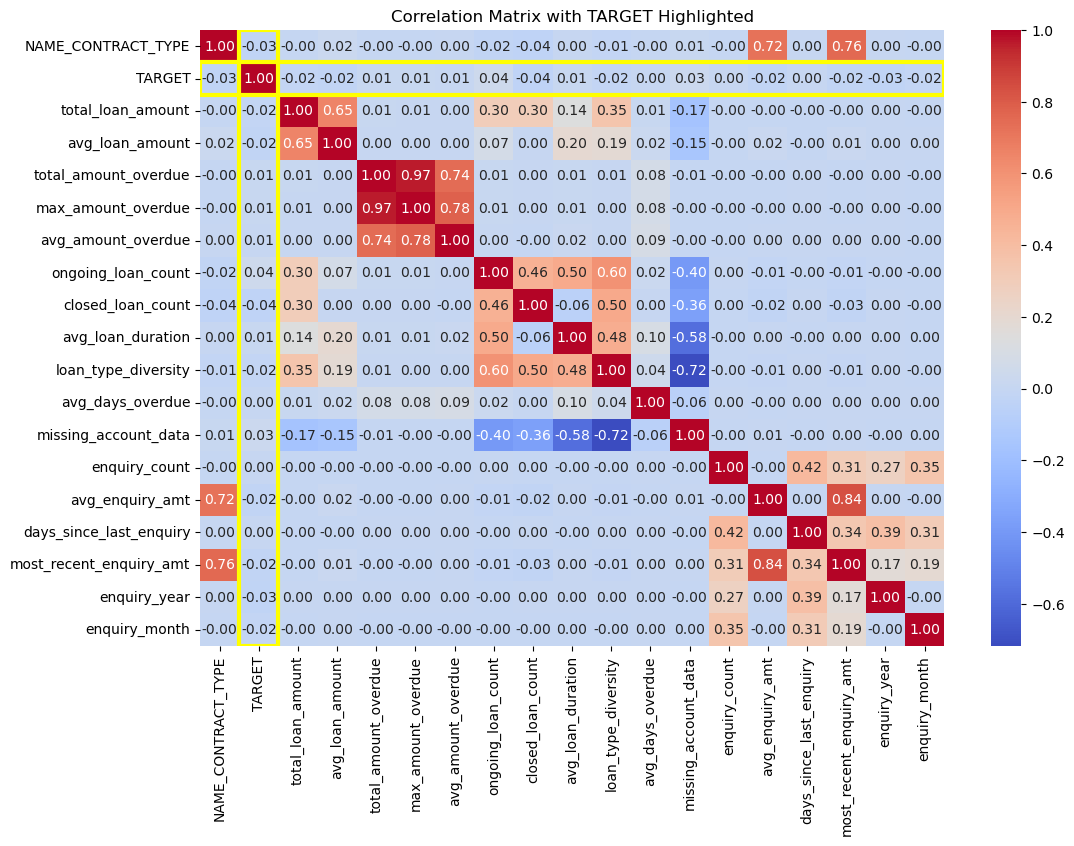

In [343]:
# Calculate the correlation matrix
corr_matrix = sel.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Highlight the TARGET row and column
for i in range(len(corr_matrix.columns)):
    if corr_matrix.columns[i] == 'TARGET':
        plt.gca().add_patch(plt.Rectangle((i, 0), 1, len(corr_matrix.columns), fill=False, edgecolor='yellow', lw=3))
        plt.gca().add_patch(plt.Rectangle((0, i), len(corr_matrix.columns), 1, fill=False, edgecolor='yellow', lw=3))

plt.title('Correlation Matrix with TARGET Highlighted')
plt.show()

In [ ]:
# seems like there are no linear relationship with target for these set of features

In [346]:
from sklearn.feature_selection import mutual_info_classif

# Selecting features and target
X = sel.drop(columns=['TARGET'])
y = sel['TARGET']

# Calculate mutual information
mi = mutual_info_classif(X, y)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display the mutual information scores
print(mi_df)

                    Feature  Mutual Information
16             enquiry_year            0.049271
14  days_since_last_enquiry            0.042127
17            enquiry_month            0.030393
9       loan_type_diversity            0.019965
15  most_recent_enquiry_amt            0.018557
13          avg_enquiry_amt            0.017828
8         avg_loan_duration            0.013670
6        ongoing_loan_count            0.007140
12            enquiry_count            0.003829
7         closed_loan_count            0.003552
0        NAME_CONTRACT_TYPE            0.002352
11     missing_account_data            0.001958
2           avg_loan_amount            0.000821
1         total_loan_amount            0.000456
5        avg_amount_overdue            0.000437
3      total_amount_overdue            0.000307
4        max_amount_overdue            0.000004
10         avg_days_overdue            0.000000


Significant Features (Higher MI Values):
- enquiry_year - 0.0493
- days_since_last_enquiry - 0.0421
- enquiry_month - 0.0304
- loan_type_diversity - 0.0200
- most_recent_enquiry_amt - 0.0186
- avg_enquiry_amt - 0.0178

In [354]:
df.to_csv('modelling.csv')

In [3]:
df = pd.read_csv('modelling.csv')

# Modelling

## XGboost

In [4]:
features = ['enquiry_year', 'days_since_last_enquiry', 'enquiry_month', 
            'loan_type_diversity', 'most_recent_enquiry_amt', 'avg_enquiry_amt']
X = df[features]
y = df['TARGET']

In [5]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Initialize the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False)

# Fit the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Training ROC AUC Score: 0.6919
Training F1 Score: 0.0033
Validation ROC AUC Score: 0.5410
Validation F1 Score: 0.0000


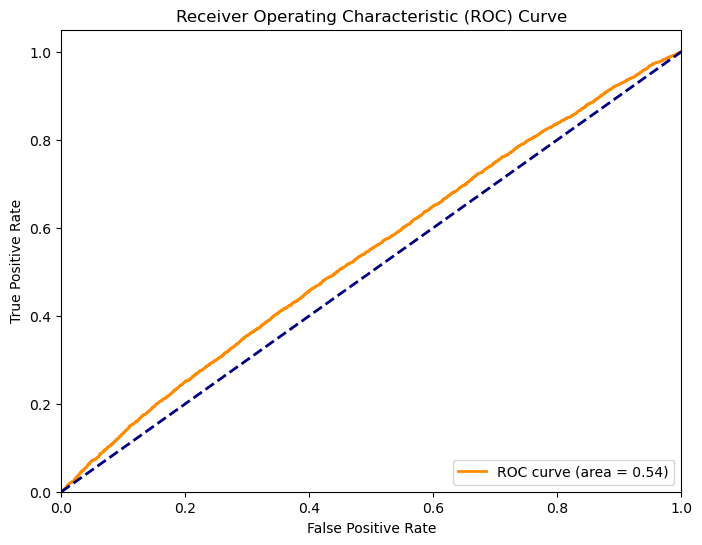

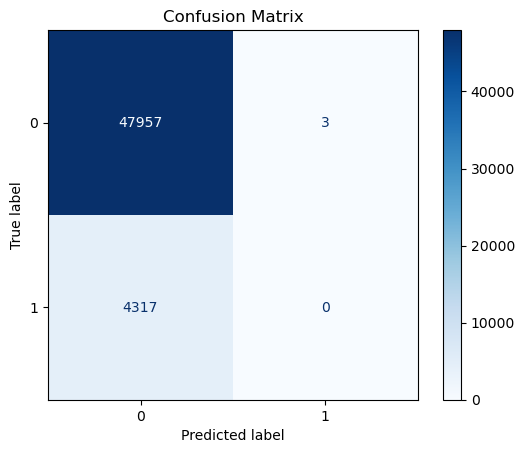

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     47960
           1       0.00      0.00      0.00      4317

    accuracy                           0.92     52277
   macro avg       0.46      0.50      0.48     52277
weighted avg       0.84      0.92      0.88     52277



In [15]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Calculate the ROC AUC and F1 score for the training set
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_train_pred = model.predict(X_train)

train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_f1 = f1_score(y_train, y_train_pred)
print(f'Training ROC AUC Score: {train_roc_auc:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')

# Calculate the ROC AUC and F1 score for the validation set
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
y_val_pred = model.predict(X_val)

val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
val_f1 = f1_score(y_val, y_val_pred)
print(f'Validation ROC AUC Score: {val_roc_auc:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

# Plot the ROC curve for the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute confusion matrix for the validation set
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for the validation set
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

<Figure size 1000x600 with 0 Axes>

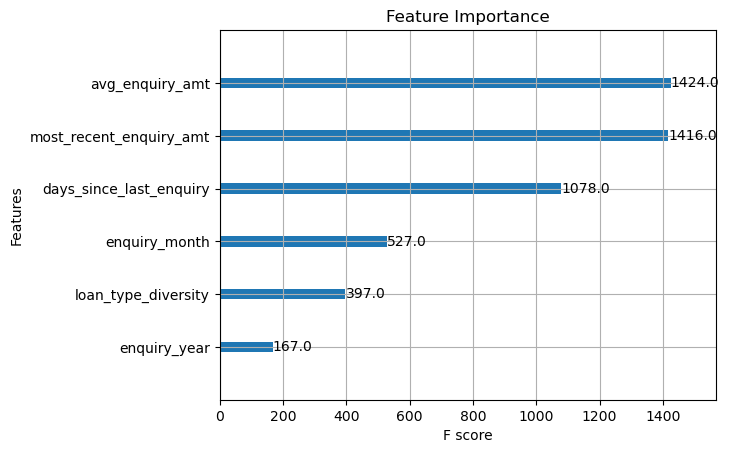

In [16]:
# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight', title='Feature Importance')
plt.show()

In [ ]:
# next we should change how we handle the missing values 
# and get better features